In [4]:
# ============================================================================
# CELL 1: Setup and Imports
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA as SKPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as SKLDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os
import cv2
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [ ]:
# ============================================================================
# CELL 2: Dataset Loading Function
# ============================================================================
def load_orl_dataset(data_path="data_faces"):
  
    images = []
    labels = []
    
    print(f"📂 Loading dataset from: {data_path}")
    
    # Try different directory structures
    if os.path.exists(data_path):
        # Structure: s1/, s2/, ...
        for subject in range(1, 41):
            subject_dir = os.path.join(data_path, f's{subject}')
            
            # Alternative naming
           # if not os.path.exists(subject_dir):
            #    subject_dir = os.path.join(data_path, f'Subject{subject:02d}')
            
            if os.path.exists(subject_dir):
                # Load images in subject directory
                img_files = sorted(glob(os.path.join(subject_dir, "*.pgm")))  
                for img_file in img_files[:10]:  # Take up to 10 images
                    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Resize if needed
                        if img.shape != (112, 92):
                            img = cv2.resize(img, (92, 112))
                        images.append(img)
                        labels.append(subject)
    
    # If no images loaded, create synthetic data for demonstration
    if len(images) == 0:
        print("⚠️ No images found. Creating synthetic data for demonstration...")
        n_subjects = 40
        n_images_per_subject = 10
        for subject in range(1, n_subjects + 1):
            base_face = np.random.randn(112, 92) * 50 + 128  # Base face pattern
            for i in range(n_images_per_subject):
                # Add some variation
                face_variation = base_face + np.random.randn(112, 92) * 20
                face_variation = np.clip(face_variation, 0, 255).astype(np.uint8)
                images.append(face_variation)
                labels.append(subject)
    
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"✅ Loaded {len(images)} images for {len(np.unique(labels))} subjects")
    print(f"📊 Image shape: {images[0].shape}")
    print(f"🏷️ Label range: {labels.min()} to {labels.max()}")
    
    return images, labels

# Load dataset
images, labels = load_orl_dataset()

📂 Loading dataset from: data_faces
✅ Loaded 400 images for 40 subjects
📊 Image shape: (112, 92)
🏷️ Label range: 1 to 40


In [9]:
# ============================================================================
# CELL 3: Dataset Statistics
# ============================================================================
print("\n📈 Dataset Statistics:")
print(f"Total images: {len(images)}")
print(f"Number of subjects: {len(np.unique(labels))}")
print(f"Images per subject: {len(images) // len(np.unique(labels))}")
print(f"Image dimensions: {images[0].shape}")
print(f"Data type: {images.dtype}")
print(f"Min pixel value: {images.min()}")
print(f"Max pixel value: {images.max()}")

# Display label distribution
label_counts = pd.Series(labels).value_counts().sort_index()
print(f"\n📊 Label distribution (first 10 subjects):")
print(label_counts.head(10))
print(f"All subjects have {label_counts.iloc[0]} images")


📈 Dataset Statistics:
Total images: 400
Number of subjects: 40
Images per subject: 10
Image dimensions: (112, 92)
Data type: uint8
Min pixel value: 0
Max pixel value: 251

📊 Label distribution (first 10 subjects):
1     10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
9     10
10    10
Name: count, dtype: int64
All subjects have 10 images


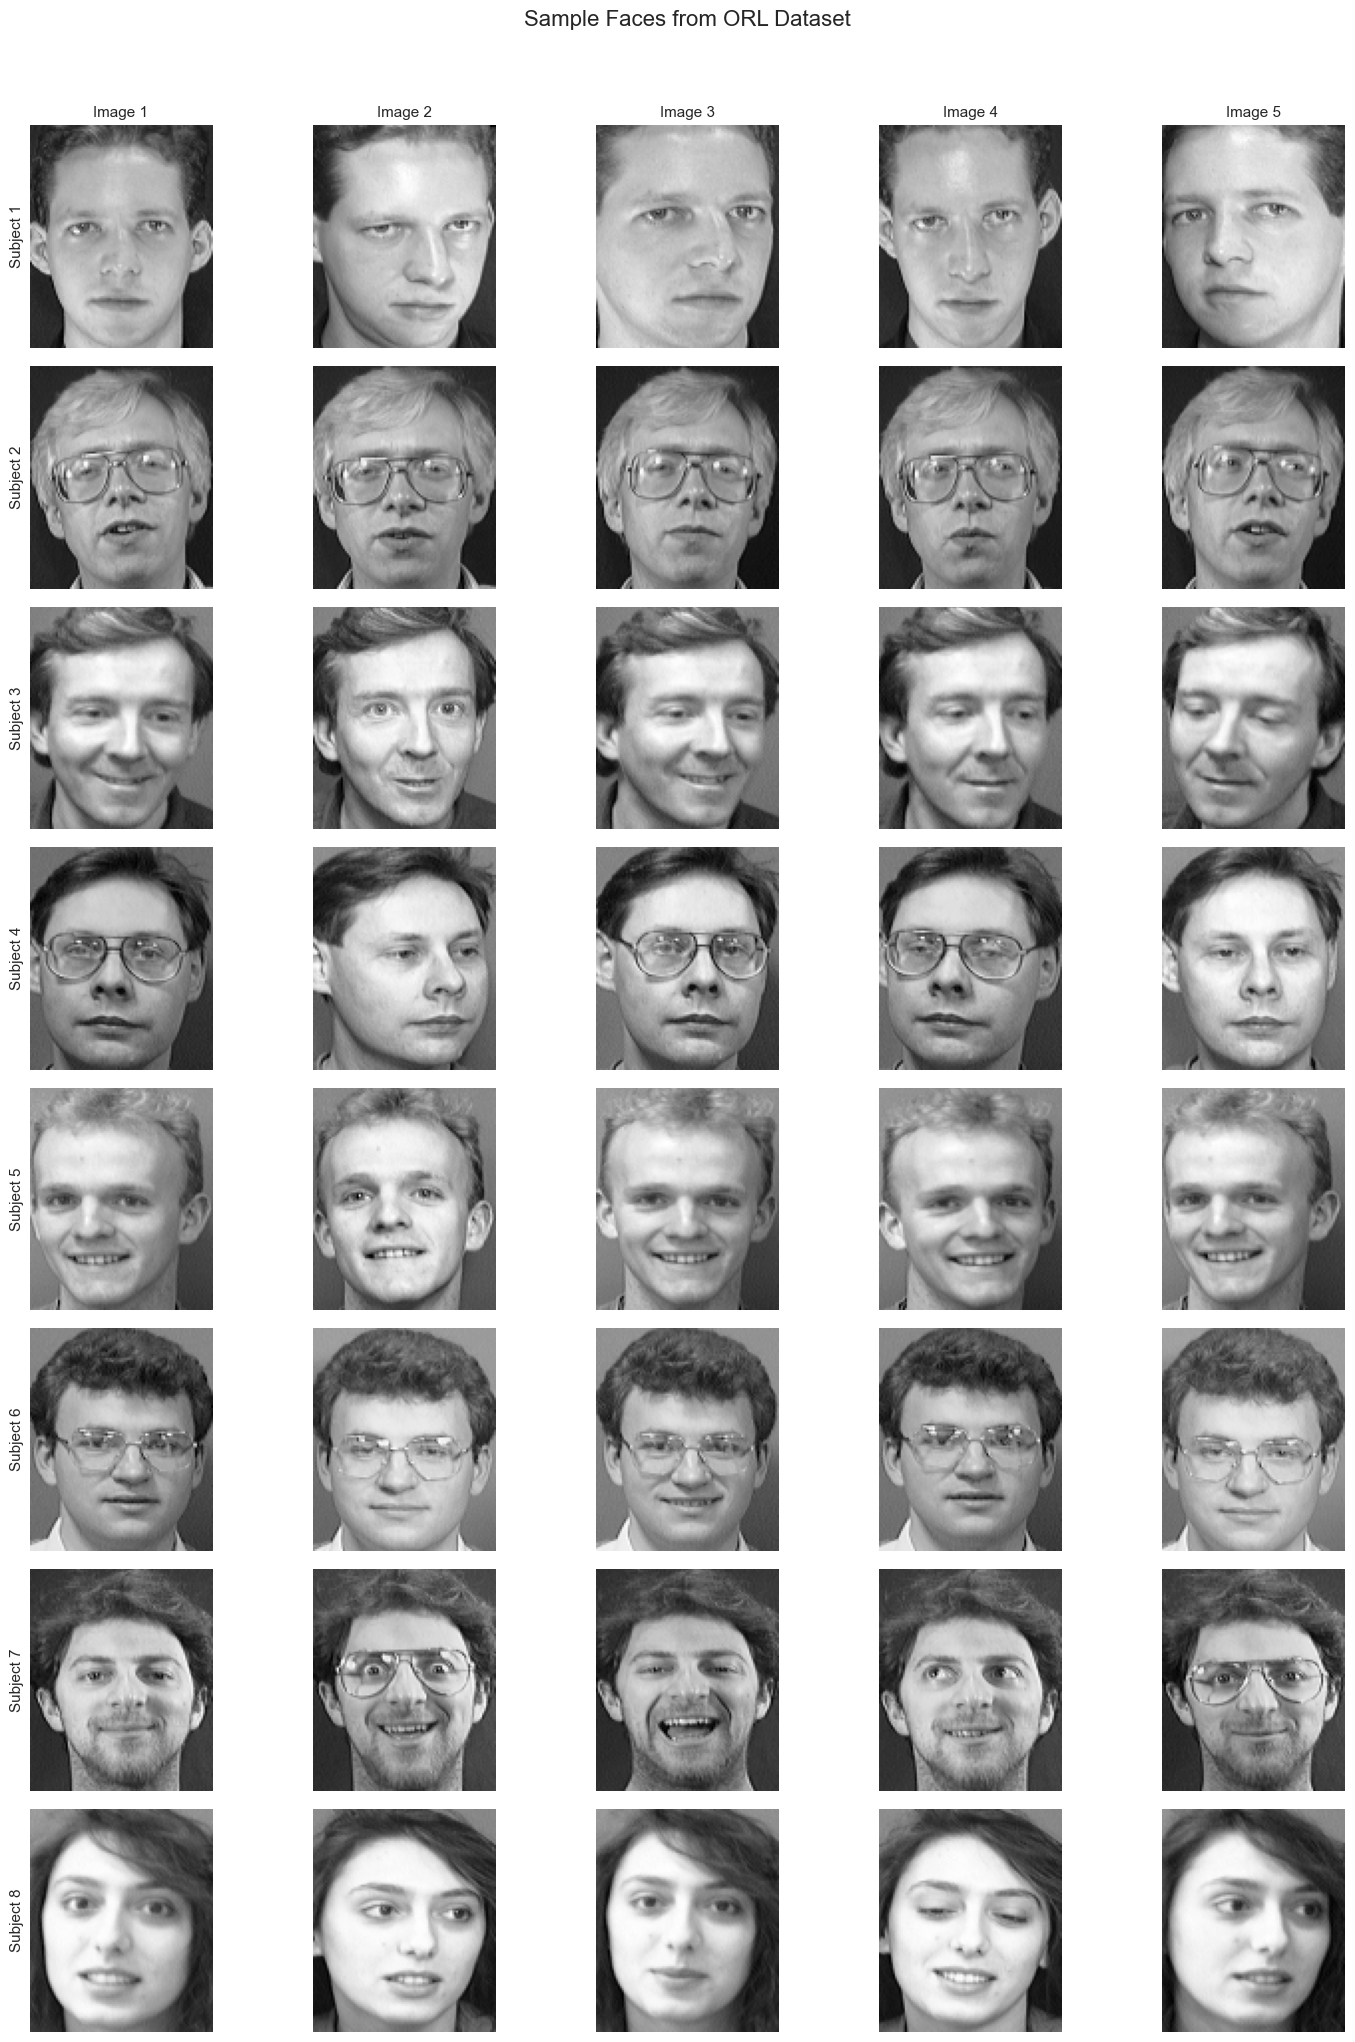

In [10]:
# ============================================================================
# CELL 4: Visualize Sample Faces
# ============================================================================
def plot_sample_faces(images, labels, n_subjects=8, n_images_per_subject=5):
    """Plot sample faces from the dataset"""
    fig, axes = plt.subplots(n_subjects, n_images_per_subject, figsize=(15, 20))
    
    unique_labels = np.unique(labels)[:n_subjects]
    
    for i, subject in enumerate(unique_labels):
        subject_images = images[labels == subject][:n_images_per_subject]
        
        for j in range(n_images_per_subject):
            ax = axes[i, j] if n_subjects > 1 else axes[j]
            if j < len(subject_images):
                ax.imshow(subject_images[j], cmap='gray')
                if j == 0:
                    ax.set_ylabel(f'Subject {subject}', fontsize=11)
            ax.set_xticks([])
            ax.set_yticks([])
            if i == 0:
                ax.set_title(f'Image {j+1}', fontsize=11)
    
    plt.suptitle('Sample Faces from ORL Dataset', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('sample_faces.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot sample faces
plot_sample_faces(images, labels)

In [12]:
# ============================================================================
# CELL 5: Create Data Matrix
# ============================================================================
def create_data_matrix(images):
    """Convert images to data matrix D (n_samples x 10304)"""
    n_samples = images.shape[0]
    D = images.reshape(n_samples, -1)
    
    print(f"📊 Data matrix shape: {D.shape}")
    print(f"📐 Each image flattened to: {D.shape[1]} features")
    
    return D

# Create data matrix
D = create_data_matrix(images)
y = labels.copy()

print(f"\n🏷️ Label vector shape: {y.shape}")

📊 Data matrix shape: (400, 10304)
📐 Each image flattened to: 10304 features

🏷️ Label vector shape: (400,)


In [13]:
# ============================================================================
# CELL 6: Split Dataset (Odd/Even Rows)
# ============================================================================
def split_odd_even(data, labels):
    """
    Split dataset: odd rows for training, even rows for testing
    (Following assignment specification)
    """
    n_samples = len(data)
    
    # Create indices (0-based: odd=0,2,4,... ; even=1,3,5,...)
    train_indices = list(range(0, n_samples, 2))
    test_indices = list(range(1, n_samples, 2))
    
    X_train = data[train_indices]
    X_test = data[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
    
    print(f"✂️ Dataset split (Odd/Even rows):")
    print(f"  Training set: {X_train.shape} ({len(train_indices)} samples)")
    print(f"  Test set: {X_test.shape} ({len(test_indices)} samples)")
    print(f"  Train subjects: {len(np.unique(y_train))}")
    print(f"  Test subjects: {len(np.unique(y_test))}")
    print(f"  Samples per subject (train): {len(X_train) // len(np.unique(y_train))}")
    print(f"  Samples per subject (test): {len(X_test) // len(np.unique(y_test))}")
    
    return X_train, X_test, y_train, y_test

# Split dataset
X_train, X_test, y_train, y_test = split_odd_even(D, y)

# Verify the split
print("\n✅ Split verification:")
print(f"First 5 training labels: {y_train[:5]}")
print(f"First 5 test labels: {y_test[:5]}")
print(f"Are all subjects in both sets? {len(np.unique(y_train)) == len(np.unique(y_test))}")

✂️ Dataset split (Odd/Even rows):
  Training set: (200, 10304) (200 samples)
  Test set: (200, 10304) (200 samples)
  Train subjects: 40
  Test subjects: 40
  Samples per subject (train): 5
  Samples per subject (test): 5

✅ Split verification:
First 5 training labels: [1 1 1 1 1]
First 5 test labels: [1 1 1 1 1]
Are all subjects in both sets? True


In [14]:
# ============================================================================
# CELL 7: Custom PCA Implementation
# mean , centered data , covariance matrix, 
# ============================================================================
def custom_pca_implementation(X_train, X_test, alpha=0.9):
    """
    Custom PCA implementation following Algorithm 7.1 from assignment
    """
    # Step 1: Compute mean
    mu = np.mean(X_train, axis=0)
    
    # Step 2: Center the data
    Z_train = X_train - mu
    Z_test = X_test - mu
    
    # Step 3: Compute covariance matrix
    n = X_train.shape[0]
    Sigma = (Z_train.T @ Z_train) / n
    
    # Step 4: Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma)
    
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Step 5: Compute fraction of total variance
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues) / total_variance
    
    # Step 6: Choose smallest r such that f(r) >= alpha
    r = np.argmax(cumulative_variance >= alpha) + 1
    
    # Step 7: Reduced basis
    U_r = eigenvectors[:, :r]
    
    # Step 8: Project data
    A_train = Z_train @ U_r
    A_test = Z_test @ U_r
    
    return A_train, A_test, r, cumulative_variance, eigenvalues

In [15]:
# ============================================================================
# CELL 8: PCA Evaluation for Different Alpha Values
# ============================================================================
def evaluate_pca_for_alphas(X_train, X_test, y_train, y_test, alphas=[0.8, 0.85, 0.9, 0.95]):
    """Evaluate PCA for different alpha values"""
    
    results = {}
    
    print("🔍 PCA Evaluation for different alpha values:")
    print("=" * 60)
    
    for alpha in alphas:
        print(f"\nα = {alpha}")
        print("-" * 40)
        
        # Apply PCA
        X_train_pca, X_test_pca, r, cum_var, eigenvalues = custom_pca_implementation(
            X_train, X_test, alpha
        )
        
        print(f"  Dimensions retained: {r}")
        print(f"  Variance retained: {cum_var[r-1]:.4f}")
        print(f"  Data shape after PCA: {X_train_pca.shape}")
        
        # Train 1-NN classifier
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train_pca, y_train)
        
        # Make predictions
        y_pred = knn.predict(X_test_pca)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store results
        results[alpha] = {
            'accuracy': accuracy,
            'dimensions': r,
            'variance_retained': cum_var[r-1],
            'train_data': X_train_pca,
            'test_data': X_test_pca,
            'eigenvalues': eigenvalues,
            'cumulative_variance': cum_var
        }
        
        print(f"  Accuracy (1-NN): {accuracy:.4f}")
        
        # Show misclassified samples for the first alpha
        if alpha == alphas[0]:
            misclassified = np.where(y_pred != y_test)[0]
            if len(misclassified) > 0:
                print(f"  Misclassified samples: {len(misclassified)}/{len(y_test)}")
    
    return results

# Define alpha values
alphas = [0.8, 0.85, 0.9, 0.95]

# Run PCA evaluation
pca_results = evaluate_pca_for_alphas(X_train, X_test, y_train, y_test, alphas)

🔍 PCA Evaluation for different alpha values:

α = 0.8
----------------------------------------
  Dimensions retained: 36
  Variance retained: 0.8016
  Data shape after PCA: (200, 36)
  Accuracy (1-NN): 0.9400
  Misclassified samples: 12/200

α = 0.85
----------------------------------------
  Dimensions retained: 52
  Variance retained: 0.8524
  Data shape after PCA: (200, 52)
  Accuracy (1-NN): 0.9400

α = 0.9
----------------------------------------
  Dimensions retained: 76
  Variance retained: 0.9012
  Data shape after PCA: (200, 76)
  Accuracy (1-NN): 0.9400

α = 0.95
----------------------------------------
  Dimensions retained: 115
  Variance retained: 0.9503
  Data shape after PCA: (200, 115)
  Accuracy (1-NN): 0.9300


In [16]:
# ============================================================================
# CELL 9: Multiclass LDA Implementation
# ============================================================================
def multiclass_lda_implementation(X_train, X_test, y_train, n_components=None):
    """
    Multiclass LDA implementation for 40 classes
    Following modified Algorithm 20.1 from assignment
    """
    n_samples, n_features = X_train.shape
    classes = np.unique(y_train)
    n_classes = len(classes)
    
    print(f"🎯 Implementing Multiclass LDA for {n_classes} classes")
    print(f"Maximum possible components: {n_classes - 1}")
    
    if n_components is None:
        n_components = n_classes - 1
    
    # Step 1: Compute overall mean
    overall_mean = np.mean(X_train, axis=0)
    
    # Step 2 & 3: Compute within-class and between-class scatter matrices
    S_w = np.zeros((n_features, n_features))
    S_b = np.zeros((n_features, n_features))
    
    for c in classes:
        # Get samples for this class
        X_c = X_train[y_train == c]
        n_k = len(X_c)
        
        # Class mean
        class_mean = np.mean(X_c, axis=0)
        
        # Center class data
        Z_c = X_c - class_mean
        
        # Within-class scatter
        S_w += Z_c.T @ Z_c
        
        # Between-class scatter
        mean_diff = (class_mean - overall_mean).reshape(-1, 1)
        S_b += n_k * (mean_diff @ mean_diff.T)
    
    print(f"   S_w shape: {S_w.shape}")
    print(f"   S_b shape: {S_b.shape}")
    
    # Handle singularity by adding regularization
    S_w_reg = S_w + 1e-6 * np.eye(n_features)
    
    # Solve generalized eigenvalue problem: S_w^{-1} S_b w = λ w
    try:
        eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.pinv(S_w_reg) @ S_b)
    except:
        # Alternative approach using scikit-learn if numpy fails
        from scipy.linalg import eigh
        eigenvalues, eigenvectors = eigh(np.linalg.pinv(S_w_reg) @ S_b)
    
    # Sort eigenvectors by eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Take top (n_components) eigenvectors
    n_components = min(n_components, n_classes - 1)
    W = eigenvectors[:, :n_components]
    
    print(f"   Selected components: {n_components}")
    
    # Project data
    X_train_lda = X_train @ W
    X_test_lda = X_test @ W
    
    print(f"   Projected train shape: {X_train_lda.shape}")
    print(f"   Projected test shape: {X_test_lda.shape}")
    
    return X_train_lda, X_test_lda, W, eigenvalues

In [17]:
# ============================================================================
# CELL 10: LDA Evaluation
# ============================================================================
def evaluate_lda(X_train, X_test, y_train, y_test, n_components=39):
    """Evaluate LDA classification"""
    
    print("\n🔍 LDA Evaluation")
    print("=" * 60)
    
    # Apply LDA
    X_train_lda, X_test_lda, W, eigenvalues = multiclass_lda_implementation(
        X_train, X_test, y_train, n_components
    )
    
    # Train 1-NN classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_lda, y_train)
    
    # Make predictions
    y_pred = knn.predict(X_test_lda)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    print(f"\n📊 LDA Results:")
    print(f"  Accuracy (1-NN): {accuracy:.4f}")
    print(f"  Misclassified: {np.sum(y_pred != y_test)}/{len(y_test)}")
    
    # Store results
    lda_results = {
        'accuracy': accuracy,
        'train_data': X_train_lda,
        'test_data': X_test_lda,
        'projection_matrix': W,
        'eigenvalues': eigenvalues,
        'confusion_matrix': cm,
        'per_class_accuracy': per_class_accuracy,
        'y_pred': y_pred
    }
    
    return lda_results

# Run LDA evaluation
lda_results = evaluate_lda(X_train, X_test, y_train, y_test, n_components=39)


🔍 LDA Evaluation
🎯 Implementing Multiclass LDA for 40 classes
Maximum possible components: 39
   S_w shape: (10304, 10304)
   S_b shape: (10304, 10304)
   Selected components: 39
   Projected train shape: (200, 39)
   Projected test shape: (200, 39)

📊 LDA Results:
  Accuracy (1-NN): 0.9600
  Misclassified: 8/200


In [18]:
# ============================================================================
# CELL 11: K-NN Classifier Tuning
# ============================================================================
def tune_knn_classifier(X_train, X_test, y_train, y_test, 
                        X_train_lda, X_test_lda, k_values=[1, 3, 5, 7]):
    """Tune K-NN classifier for different K values"""
    
    print("K-NN Classifier Tuning")
    print("=" * 60)
    
    pca_knn_results = {}
    lda_knn_results = {}
    
    # Best PCA configuration (using highest accuracy)
    best_alpha = max(pca_results, key=lambda x: pca_results[x]['accuracy'])
    X_train_pca_best = pca_results[best_alpha]['train_data']
    X_test_pca_best = pca_results[best_alpha]['test_data']
    
    print(f"Using PCA with α={best_alpha} (Accuracy: {pca_results[best_alpha]['accuracy']:.4f})")
    print(f"Using LDA (Accuracy: {lda_results['accuracy']:.4f})")
    print("\n" + "-" * 60)
    
    # Test different K values
    for k in k_values:
        print(f"\nK = {k}")
        print("-" * 30)
        
        # PCA + K-NN
        knn_pca = KNeighborsClassifier(n_neighbors=k)
        knn_pca.fit(X_train_pca_best, y_train)
        y_pred_pca = knn_pca.predict(X_test_pca_best)
        acc_pca = accuracy_score(y_test, y_pred_pca)
        pca_knn_results[k] = acc_pca
        print(f"  PCA Accuracy: {acc_pca:.4f}")
        
        # LDA + K-NN
        knn_lda = KNeighborsClassifier(n_neighbors=k)
        knn_lda.fit(X_train_lda, y_train)
        y_pred_lda = knn_lda.predict(X_test_lda)
        acc_lda = accuracy_score(y_test, y_pred_lda)
        lda_knn_results[k] = acc_lda
        print(f"  LDA Accuracy: {acc_lda:.4f}")
        
        # Difference
        diff = acc_lda - acc_pca
        print(f"  Difference (LDA - PCA): {diff:+.4f}")
    
    return pca_knn_results, lda_knn_results, best_alpha

# Define K values
k_values = [1, 3, 5, 7]

# Run K-NN tuning
pca_knn_results, lda_knn_results, best_alpha = tune_knn_classifier(
    None, None, y_train, y_test,
    lda_results['train_data'], lda_results['test_data'],
    k_values
)

K-NN Classifier Tuning
Using PCA with α=0.8 (Accuracy: 0.9400)
Using LDA (Accuracy: 0.9600)

------------------------------------------------------------

K = 1
------------------------------
  PCA Accuracy: 0.9400
  LDA Accuracy: 0.9600
  Difference (LDA - PCA): +0.0200

K = 3
------------------------------
  PCA Accuracy: 0.8550
  LDA Accuracy: 0.9200
  Difference (LDA - PCA): +0.0650

K = 5
------------------------------
  PCA Accuracy: 0.8000
  LDA Accuracy: 0.9150
  Difference (LDA - PCA): +0.1150

K = 7
------------------------------
  PCA Accuracy: 0.7650
  LDA Accuracy: 0.8950
  Difference (LDA - PCA): +0.1300


In [19]:
# ============================================================================
# CELL 12:Load Non-Face Images
# ============================================================================
def load_non_face_images(data_path="nonfaces", target_size=(112, 92), n_images=100):
    """Load non-face images from a folder on your laptop"""
    
    non_face_images = []
    
    print(f"📂 Looking for non-face images in: {data_path}")
    
    # Check if the directory exists
    if os.path.exists(data_path):
        print(f"✅ Found directory: {data_path}")
        
        # Get all image files in the directory
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.pgm', '*.tiff', '*.tif']
        image_files = []
        
        for ext in image_extensions:
            # Search in current directory
            image_files.extend(glob(os.path.join(data_path, ext)))
            # Search in subdirectories recursively
            image_files.extend(glob(os.path.join(data_path, '**', ext), recursive=True))
        
        print(f"   Found {len(image_files)} image files")
        
        if len(image_files) == 0:
            print("⚠️ No image files found in the directory")
            print("   Supported formats: .jpg, .jpeg, .png, .bmp, .pgm")
        else:
            # Load and process images
            loaded_count = 0
            for img_path in image_files[:n_images]:  # Limit to n_images
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Resize to target size
                        img_resized = cv2.resize(img, (target_size[1], target_size[0]))
                        non_face_images.append(img_resized)
                        loaded_count += 1
                        
                        # Show progress every 20 images
                        if loaded_count % 20 == 0:
                            print(f"   Loaded {loaded_count} images...")
                except Exception as e:
                    print(f"   Warning: Could not load {img_path}: {e}")
                    continue
            
            print(f"✅ Successfully loaded {len(non_face_images)} non-face images")
    
    else:
        print(f"⚠️ Directory not found: {data_path}")
        print("   Creating synthetic non-face images for demonstration...")
        
        # Create synthetic non-face images
        for i in range(n_images):
            # Create random patterns (not face-like)
            if i % 3 == 0:
                # Random noise
                img = np.random.randint(0, 256, target_size, dtype=np.uint8)
            elif i % 3 == 1:
                # Gradient
                x = np.linspace(0, 255, target_size[1])
                y = np.linspace(0, 255, target_size[0])
                X, Y = np.meshgrid(x, y)
                img = ((X + Y) / 2).astype(np.uint8)
            else:
                # Textures (like clouds or patterns)
                img = np.random.randn(*target_size) * 30 + 128
                img = np.clip(img, 0, 255).astype(np.uint8)
            
            non_face_images.append(img)
        
        print(f"✅ Created {len(non_face_images)} synthetic non-face images")
    
    return np.array(non_face_images)

# Load non-face images
print("=" * 60)
print("LOADING NON-FACE IMAGES FOR BONUS TASK")
print("=" * 60)

# Try different paths - modify these to match your folder location
possible_paths = [
    "nonfaces",                    # Current directory
    "./nonfaces",                  # Current directory
    "../nonfaces",                 # Parent directory
    "non_face_images",             # Alternative name
    "./non_face_images",           # Alternative name
    "C:/Users/YourName/Desktop/nonfaces",  # Windows example
    "/home/yourname/Desktop/nonfaces",     # Linux/Mac example
    "/Users/yourname/Desktop/nonfaces",    # Mac example
    "D:/nonfaces",                         # Another drive
]

# Try each path
for path in possible_paths:
    if os.path.exists(path):
        print(f"📁 Using non-face images from: {path}")
        non_face_images = load_non_face_images(data_path=path, n_images=100)
        break
else:
    # If no path found, use current directory or create synthetic
    print("⚠️ No non-face folder found. Trying current directory...")
    non_face_images = load_non_face_images(n_images=100)

print(f"\n📊 Non-face images loaded: {len(non_face_images)}")
if len(non_face_images) > 0:
    print(f"   Shape: {non_face_images.shape}")
    print(f"   Data type: {non_face_images.dtype}")
    print(f"   Min pixel value: {non_face_images.min()}")
    print(f"   Max pixel value: {non_face_images.max()}")

LOADING NON-FACE IMAGES FOR BONUS TASK
📁 Using non-face images from: nonfaces
📂 Looking for non-face images in: nonfaces
✅ Found directory: nonfaces
   Found 549 image files
   Loaded 20 images...
   Loaded 40 images...
   Loaded 60 images...
   Loaded 80 images...
   Loaded 100 images...
✅ Successfully loaded 100 non-face images

📊 Non-face images loaded: 100
   Shape: (100, 112, 92)
   Data type: uint8
   Min pixel value: 0
   Max pixel value: 255


In [21]:
# ============================================================================
# CELL 13: Faces vs Non-Faces Classification
# ============================================================================
def faces_vs_nonfaces_classification(face_images, face_labels, non_face_images, n_face_samples=40):
    """Binary classification: Faces vs Non-faces"""
    
    print("\n🎭 FACES VS NON-FACES CLASSIFICATION")
    print("=" * 60)
    
    # Prepare data
    n_faces = min(n_face_samples, len(face_images))
    n_non_faces = len(non_face_images)
    
    print(f"Using {n_faces} face images and {n_non_faces} non-face images")
    
    # Create face data
    X_faces = face_images[:n_faces].reshape(n_faces, -1)
    X_non_faces = non_face_images.reshape(n_non_faces, -1)
    
    # Combine data
    X = np.vstack([X_faces, X_non_faces])
    y = np.concatenate([np.ones(n_faces), np.zeros(n_non_faces)])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"\nTrain set: {X_train.shape} ({np.sum(y_train == 1)} faces, {np.sum(y_train == 0)} non-faces)")
    print(f"Test set: {X_test.shape} ({np.sum(y_test == 1)} faces, {np.sum(y_test == 0)} non-faces)")
    
    # Apply LDA (binary classification)
    print("\n🔍 Applying LDA for binary classification...")
    lda = SKLDA(n_components=1)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    
    # Train classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_lda, y_train)
    
    # Make predictions
    y_pred = knn.predict(X_test_lda)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n📊 Classification Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    
    baseline_acc = np.sum(y_test == 0) / len(y_test)
    # Critique accuracy measure
    print("\n" + "=" * 60)
    print("CRITIQUE OF ACCURACY MEASURE")
    print("=" * 60)
    print(f"\nBaseline (always predict non-face): {baseline_acc:.4f}")
    print(f"Our model accuracy: {accuracy:.4f}")
    print(f"Improvement: {(accuracy - baseline_acc):+.4f}")
    
    return accuracy, cm

# Run faces vs non-faces classification
if len(non_face_images) > 0:
    face_nonface_acc, face_nonface_cm = faces_vs_nonfaces_classification(
        images, labels, non_face_images, n_face_samples=40
    )
else:
    print("❌ Cannot run faces vs non-faces classification without non-face images")


🎭 FACES VS NON-FACES CLASSIFICATION
Using 40 face images and 100 non-face images

Train set: (98, 10304) (28 faces, 70 non-faces)
Test set: (42, 10304) (12 faces, 30 non-faces)

🔍 Applying LDA for binary classification...

📊 Classification Results:
  Accuracy: 0.9524

CRITIQUE OF ACCURACY MEASURE

Baseline (always predict non-face): 0.7143
Our model accuracy: 0.9524
Improvement: +0.2381
